<a href="https://colab.research.google.com/github/SteamMachinist/Maxwell_triangle_CIE_1931_XYZ/blob/main/Maxwell_triangle_CIE_1931_XYZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from PIL import Image

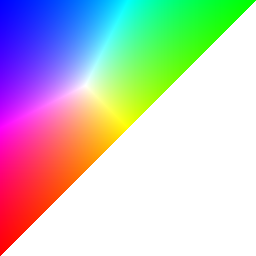

In [ ]:
img = Image.new('RGB', (256, 256), "white")
pixels = img.load()
for x in range(256):
    for y in range(256 - x):
        rRatio = y / 255.0;
        gRatio = x / 255.0;
        bRatio = 1.0 - rRatio - gRatio;
        factor = 1 / max([rRatio, gRatio, bRatio])
        r = (int)(255 * factor * rRatio);
        g = (int)(255 * factor * gRatio);
        b = (int)(255 * factor * bRatio);
        pixels[x, y] = (r, g, b)
display(img)

In [ ]:
RGB_to_XYZ_matrix = np.array([[0.49000, 0.31000, 0.20000],
                              [0.17697, 0.81240, 0.01063],
                              [0.00000, 0.01000, 0.99000]])
XYZ_to_RGB_matrix = np.linalg.inv(RGB_to_XYZ_matrix)

gamma_correct = lambda v: 12.92 * v if v <= 0.0031308 else 1.055 * (v ** (1 / 2.4)) - 0.055
inverse_gamma = lambda v: v / 12.92 if v <= 0.04045 else ((v + 0.055) / 1.055) ** 2.4

def rgb_to_xyz(rgb):
    rgb = [inverse_gamma(c / 255.0) for c in rgb]
    return np.dot(RGB_to_XYZ_matrix, rgb)


def xyz_to_rgb(xyz):
    rgb = np.dot(XYZ_to_RGB_matrix, xyz)
    return [int(np.clip(gamma_correct(c) * 255, 0, 255)) for c in rgb]


In [ ]:
lrgb = pd.read_csv('RGB.csv', header=None, delimiter=';')
rgb = lrgb.drop(columns=[0]).values
xyz = np.array([rgb_to_xyz(elem) for elem in rgb])

X = xyz[:, 0]
Y = xyz[:, 1]
Z = xyz[:, 2]

S = (X + Y + Z)
x = X / S
y = Y / S

border = [t for t in zip(x, y)]

In [ ]:
grid_size = 600
grid_sizes = (grid_size, grid_size)

In [ ]:
def generate_grid_within_polygon(polygon_path, grid_size):
    x_grid = np.linspace(0, 1, grid_size[0])
    y_grid = np.linspace(0, 1, grid_size[1])

    points = []
    for x in x_grid:
        for y in y_grid:
            if polygon_path.contains_point((x, y)):
                points.append((x, y))

    return points

points_within_polygon = generate_grid_within_polygon(Path(border), grid_sizes)

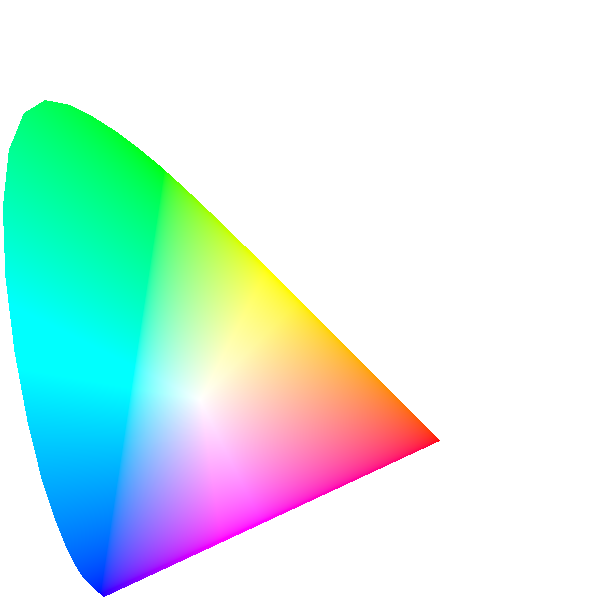

In [ ]:
img = Image.new('RGB', grid_sizes, "white")
pixels = img.load()

for point in points_within_polygon:
    x = point[0] * grid_size
    y = grid_size - point[1] * grid_size

    xr = point[0]
    yr = point[1]
    zr = 1.0 - xr - yr;

    factor = 1 / max([xr, yr, zr])
    xr = factor * xr;
    yr = factor * yr;
    zr = factor * zr;

    rgb = xyz_to_rgb([xr, yr, zr]);

    pixels[x, y] = (rgb[0], rgb[1], rgb[2])

display(img)